🧩 Cell 1 – Import + Konfigurasi Path & HPO Grid

In [9]:
# Cell 1: Import dan konfigurasi dasar

import os
import glob
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# === PATH DASAR (SESUAI STRUKTUR KAMU) ===

BASE_DIR = r"E:\0.TA_Teguh\dataset2"

# Folder raw (di dalamnya ada folder per subjek: Afi, Tsania, Tsamara)
RAW_DIR = BASE_DIR  # contoh: E:\0.TA_Teguh\dataset2\Afi\Jalan1.csv

# Folder output clustering dan torso (per subjek)
CLUSTER_DIR = os.path.join(BASE_DIR, "hasil_clustering")
TORSO_DIR   = os.path.join(BASE_DIR, "hasil_torso")  # dipakai nanti untuk branch torso

# Daftar subjek (folder) yang akan diproses
SUBJECTS = ["Afi", "Tsania", "Tsamara"]

# Pastikan folder hasil_clustering & hasil_torso + subfolder per subjek ada
for subj in SUBJECTS:
    os.makedirs(os.path.join(CLUSTER_DIR, subj), exist_ok=True)
    os.makedirs(os.path.join(TORSO_DIR,   subj), exist_ok=True)

# === MODE PERLAKUAN FRAME KURUS ===
# Jika titik dalam 1 frame < min_samples dan > 0 → mau dianggap 1 cluster kecil atau noise semua?
SMALL_FRAME_AS_SINGLE_CLUSTER = True

# === GRID PARAMETER UNTUK HPO (cari eps & min_samples terbaik) ===
EPS_CANDIDATES         = [0.25, 0.28, 0.30, 0.32, 0.35, 0.37, 0.38, 0.39, 0.40, 0.42, 0.44, 0.46, 0.50]
MIN_SAMPLES_CANDIDATES = [5, 8, 10, 12, 15, 17, 20]

# Berapa banyak file sampel per subjek untuk HPO
HPO_MAX_FILES_PER_SUBJECT = None


🧩 Cell 2 – Utility: List File Mentah Per Subjek

In [10]:
# Cell 2: Fungsi untuk mengambil semua file raw per subjek

def list_raw_files_for_subject(subject_name: str):
    """
    Mengembalikan list path penuh ke semua file CSV mentah
    untuk satu subjek, misal:
    E:\0.TA_Teguh\dataset2\Afi\Jalan1.csv, Jalan2.csv, dst.
    """
    subj_dir = os.path.join(RAW_DIR, subject_name)
    pattern = os.path.join(subj_dir, "*.csv")
    files = sorted(glob.glob(pattern))
    return files

# (Opsional) Cek cepat isi per subjek
for subj in SUBJECTS:
    files = list_raw_files_for_subject(subj)
    print(f"Subjek {subj}: {len(files)} file ditemukan")
    for f in files:
        print("  ", os.path.basename(f))
    print()


Subjek Afi: 72 file ditemukan
   Jalan1.csv
   Jalan10.csv
   Jalan11.csv
   Jalan12.csv
   Jalan13.csv
   Jalan14.csv
   Jalan15.csv
   Jalan16.csv
   Jalan17.csv
   Jalan18.csv
   Jalan19.csv
   Jalan2.csv
   Jalan20.csv
   Jalan21.csv
   Jalan22.csv
   Jalan23.csv
   Jalan24.csv
   Jalan25.csv
   Jalan26.csv
   Jalan27.csv
   Jalan28.csv
   Jalan29.csv
   Jalan3.csv
   Jalan30.csv
   Jalan31.csv
   Jalan32.csv
   Jalan33.csv
   Jalan34.csv
   Jalan35.csv
   Jalan36.csv
   Jalan37.csv
   Jalan38.csv
   Jalan39.csv
   Jalan4.csv
   Jalan40.csv
   Jalan41.csv
   Jalan42.csv
   Jalan43.csv
   Jalan44.csv
   Jalan45.csv
   Jalan46.csv
   Jalan47.csv
   Jalan48.csv
   Jalan49.csv
   Jalan5.csv
   Jalan50.csv
   Jalan51.csv
   Jalan52.csv
   Jalan53.csv
   Jalan54.csv
   Jalan55.csv
   Jalan56.csv
   Jalan57.csv
   Jalan58.csv
   Jalan59.csv
   Jalan6.csv
   Jalan60.csv
   Jalan61.csv
   Jalan62.csv
   Jalan63.csv
   Jalan64.csv
   Jalan65.csv
   Jalan66.csv
   Jalan67.csv
   Jalan68.csv
 

🧩 Cell 3 – DBSCAN untuk Satu Frame

In [11]:
# Cell 3: DBSCAN untuk 1 frame

def run_dbscan_on_frame(df_frame: pd.DataFrame,
                        eps: float,
                        min_samples: int,
                        small_frame_as_single_cluster: bool = True) -> np.ndarray:
    """
    Menerima subset DataFrame untuk 1 frame (kolom x, y, z),
    mengembalikan array cluster_id untuk tiap titik di frame itu.
    
    - Jika jumlah titik >= min_samples → jalankan DBSCAN normal.
    - Jika 0 titik → kembalikan array kosong.
    - Jika 0 < jumlah titik < min_samples:
        - Jika small_frame_as_single_cluster=True → semua titik cluster 0.
        - Jika False → semua titik noise (-1).
    """
    if df_frame.empty:
        return np.array([], dtype=int)
    
    coords = df_frame[["x", "y", "z"]].values
    n_points = coords.shape[0]
    
    if n_points >= min_samples:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(coords)
        return labels.astype(int)
    else:
        if small_frame_as_single_cluster:
            labels = np.zeros(n_points, dtype=int)   # semua cluster 0
        else:
            labels = -np.ones(n_points, dtype=int)   # semua noise
        return labels


🧩 Cell 4 – Evaluasi Param DBSCAN untuk 1 File (HPO)

In [12]:
# Cell 4: Evaluasi kualitas DBSCAN untuk 1 file (tanpa menyimpan CSV)

def evaluate_dbscan_params_on_file(input_path: str,
                                   eps: float,
                                   min_samples: int,
                                   small_frame_as_single_cluster: bool = True):
    """
    Jalankan DBSCAN per frame untuk satu file, lalu hitung metrik:
    - total_frames
    - frames_with_non_noise : frame yang punya cluster_id != -1
    - coverage              : frames_with_non_noise / total_frames
    - avg_clusters_per_frame: rata-rata jumlah cluster non-noise per frame
    - avg_non_noise_points  : rata-rata jumlah titik non-noise per frame
    """
    df = pd.read_csv(input_path)
    if "frame" not in df.columns:
        raise ValueError("Kolom 'frame' tidak ditemukan di file: " + input_path)
    
    frame_groups = df.groupby("frame").groups
    total_frames = len(frame_groups)
    
    frames_with_non_noise = 0
    clusters_count_list = []
    non_noise_points_list = []
    
    for frame_id, idx in frame_groups.items():
        df_frame = df.loc[idx]
        labels = run_dbscan_on_frame(
            df_frame,
            eps=eps,
            min_samples=min_samples,
            small_frame_as_single_cluster=small_frame_as_single_cluster
        )
        
        if labels.size == 0:
            clusters_count_list.append(0)
            non_noise_points_list.append(0)
            continue
        
        non_noise_mask = (labels != -1)
        non_noise_labels = labels[non_noise_mask]
        
        if non_noise_labels.size > 0:
            frames_with_non_noise += 1
            unique_clusters = np.unique(non_noise_labels)
            clusters_count_list.append(len(unique_clusters))
            non_noise_points_list.append(non_noise_labels.size)
        else:
            clusters_count_list.append(0)
            non_noise_points_list.append(0)
    
    coverage = frames_with_non_noise / total_frames if total_frames > 0 else 0.0
    avg_clusters_per_frame = np.mean(clusters_count_list) if clusters_count_list else 0.0
    avg_non_noise_points = np.mean(non_noise_points_list) if non_noise_points_list else 0.0
    
    return {
        "file": input_path,
        "eps": eps,
        "min_samples": min_samples,
        "total_frames": total_frames,
        "frames_with_non_noise": frames_with_non_noise,
        "coverage": coverage,
        "avg_clusters_per_frame": avg_clusters_per_frame,
        "avg_non_noise_points": avg_non_noise_points,
    }


🧩 Cell 5 – HPO: Coba Semua Kombinasi eps × min_samples di Beberapa File

In [ ]:
# Cell 5: HPO sederhana untuk DBSCAN di beberapa file sampel

def run_hpo_dbscan(sample_subjects=None,
                   max_files_per_subject=HPO_MAX_FILES_PER_SUBJECT):
    """
    Jalankan evaluasi DBSCAN untuk grid eps x min_samples
    di beberapa file sampel dari tiap subjek.
    
    sample_subjects: list subjek yang mau diikutkan (default: SUBJECTS)
    """
    if sample_subjects is None:
        sample_subjects = SUBJECTS
    
    results = []
    
    for subj in sample_subjects:
        raw_files = list_raw_files_for_subject(subj)
        if not raw_files:
            print(f"[HPO] Tidak ada file untuk subjek {subj}")
            continue
        
        sample_files = raw_files[:max_files_per_subject]
        print(f"[HPO] Subjek {subj}, sample files:")
        for f in sample_files:
            print("    ", os.path.basename(f))
        print()
        
        for fpath in sample_files:
            for eps in EPS_CANDIDATES:
                for ms in MIN_SAMPLES_CANDIDATES:
                    metrics = evaluate_dbscan_params_on_file(
                        input_path=fpath,
                        eps=eps,
                        min_samples=ms,
                        small_frame_as_single_cluster=SMALL_FRAME_AS_SINGLE_CLUSTER
                    )
                    metrics["subject"] = subj
                    results.append(metrics)
    
    if not results:
        print("Tidak ada hasil HPO (cek kembali folder dan SUBJECTS).")
        return None, None
    
    df_res = pd.DataFrame(results)
    
    # Skor sederhana:
    # score = coverage - penalty * |avg_clusters_per_frame - 1|
    penalty = 0.3
    df_res["score"] = df_res["coverage"] - penalty * (df_res["avg_clusters_per_frame"] - 1).abs()
    
    df_res_sorted = df_res.sort_values(by=["score", "coverage"], ascending=False)
    
    return df_res, df_res_sorted


In [14]:
# Cell 5b: Jalankan HPO dan pilih kombinasi terbaik (berdasarkan score)

df_hpo, df_hpo_sorted = run_hpo_dbscan()

if df_hpo is None or df_hpo_sorted is None or df_hpo_sorted.empty:
    raise RuntimeError("HPO gagal atau tidak menghasilkan data. Cek kembali folder dan parameter.")
    
# Lihat 10 kombinasi terbaik (opsional)
print("Top 10 kombinasi HPO (per file):")
print(df_hpo_sorted.head(10))

# Ambil baris pertama sebagai kombinasi terbaik (skor tertinggi)
best_row = df_hpo_sorted.iloc[0]
BEST_EPS         = float(best_row["eps"])
BEST_MIN_SAMPLES = int(best_row["min_samples"])

print("\nKombinasi terbaik (berdasarkan score per file):")
print("  eps        =", BEST_EPS)
print("  min_samples=", BEST_MIN_SAMPLES)


[HPO] Subjek Afi, sample files:
     Jalan1.csv
     Jalan10.csv
     Jalan11.csv
     Jalan12.csv
     Jalan13.csv
     Jalan14.csv
     Jalan15.csv
     Jalan16.csv
     Jalan17.csv
     Jalan18.csv
     Jalan19.csv
     Jalan2.csv
     Jalan20.csv
     Jalan21.csv
     Jalan22.csv
     Jalan23.csv
     Jalan24.csv
     Jalan25.csv
     Jalan26.csv
     Jalan27.csv
     Jalan28.csv
     Jalan29.csv
     Jalan3.csv
     Jalan30.csv
     Jalan31.csv
     Jalan32.csv
     Jalan33.csv
     Jalan34.csv
     Jalan35.csv
     Jalan36.csv
     Jalan37.csv
     Jalan38.csv
     Jalan39.csv
     Jalan4.csv
     Jalan40.csv
     Jalan41.csv
     Jalan42.csv
     Jalan43.csv
     Jalan44.csv
     Jalan45.csv
     Jalan46.csv
     Jalan47.csv
     Jalan48.csv
     Jalan49.csv
     Jalan5.csv
     Jalan50.csv
     Jalan51.csv
     Jalan52.csv
     Jalan53.csv
     Jalan54.csv
     Jalan55.csv
     Jalan56.csv
     Jalan57.csv
     Jalan58.csv
     Jalan59.csv
     Jalan6.csv
     Jalan60.csv
     

🧩 Cell 6 – Set Parameter Final DBSCAN dari Hasil HPO

In [15]:
# Cell 6: Set parameter DBSCAN FINAL berdasarkan hasil HPO

# Gunakan hasil terbaik dari Cell 5b
DBSCAN_EPS_FINAL         = BEST_EPS
DBSCAN_MIN_SAMPLES_FINAL = BEST_MIN_SAMPLES

print("Parameter DBSCAN final (dari HPO):")
print("  eps        =", DBSCAN_EPS_FINAL)
print("  min_samples=", DBSCAN_MIN_SAMPLES_FINAL)



Parameter DBSCAN final (dari HPO):
  eps        = 0.37
  min_samples= 17


🧩 Cell 7 – Proses 1 File: Tambah cluster_id dan Simpan ke hasil_clustering

In [16]:
# Cell 7: Proses 1 file raw → simpan file clustering (dengan cluster_id)

def build_output_cluster_path(subject_name: str, input_file_path: str) -> str:
    """
    Dari path input, misal:
        E:\0.TA_Teguh\dataset2\Afi\Jalan1.csv
    hasilkan path output:
        E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan1.csv
    """
    fname = os.path.basename(input_file_path)      # "Jalan1.csv"
    output_fname = f"clustering_{fname}"          # "clustering_Jalan1.csv"
    subj_out_dir = os.path.join(CLUSTER_DIR, subject_name)
    return os.path.join(subj_out_dir, output_fname)


def process_single_file_dbscan(input_path: str,
                               output_path: str,
                               eps: float,
                               min_samples: int,
                               small_frame_as_single_cluster: bool = True):
    """
    Membaca file CSV mentah (timestamp, frame, x, y, z, doppler, SNR),
    melakukan DBSCAN per frame, menambahkan kolom cluster_id,
    lalu menyimpannya ke output_path.
    """
    print(f"Memproses file: {input_path}")
    df = pd.read_csv(input_path)
    
    if "frame" not in df.columns:
        raise ValueError("Kolom 'frame' tidak ditemukan dalam file: " + input_path)
    
    cluster_ids = np.full(len(df), -1, dtype=int)  # default noise
    
    for frame_id, idx in df.groupby("frame").groups.items():
        df_frame = df.loc[idx]
        labels = run_dbscan_on_frame(
            df_frame,
            eps=eps,
            min_samples=min_samples,
            small_frame_as_single_cluster=small_frame_as_single_cluster
        )
        cluster_ids[list(idx)] = labels
    
    df["cluster_id"] = cluster_ids
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"  >> Disimpan ke: {output_path}")


🧩 Cell 8 – Jalankan DBSCAN untuk Semua Subjek & Semua File (Fase Produksi)

In [17]:
# Cell 8: Jalankan DBSCAN final untuk semua subjek & semua file raw

def run_dbscan_for_all_subjects(eps_final: float,
                                min_samples_final: int,
                                small_frame_as_single_cluster: bool = True):
    """
    Menggunakan parameter final hasil HPO,
    jalankan DBSCAN untuk semua file raw semua subjek,
    dan simpan hasil ke folder hasil_clustering/<subjek>/clustering_JalanN.csv
    """
    for subj in SUBJECTS:
        print("=" * 60)
        print(f"Subjek: {subj}")
        print("=" * 60)
        
        raw_files = list_raw_files_for_subject(subj)
        if not raw_files:
            print(f"  Tidak ada file CSV untuk subjek {subj}")
            continue
        
        for raw_path in raw_files:
            out_path = build_output_cluster_path(subj, raw_path)
            process_single_file_dbscan(
                input_path=raw_path,
                output_path=out_path,
                eps=eps_final,
                min_samples=min_samples_final,
                small_frame_as_single_cluster=small_frame_as_single_cluster
            )
        print()

# Contoh pemanggilan (FASE 2, setelah HPO & set param final):
run_dbscan_for_all_subjects(DBSCAN_EPS_FINAL, DBSCAN_MIN_SAMPLES_FINAL)


Subjek: Afi
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan1.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan1.csv
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan10.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan10.csv
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan11.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan11.csv
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan12.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan12.csv
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan13.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan13.csv
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan14.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan14.csv
Memproses file: E:\0.TA_Teguh\dataset2\Afi\Jalan15.csv
  >> Disimpan ke: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan15.csv
Memproses 

🧩 Cell 9 (Opsional) – Ringkasan Cepat 1 File Clustering

In [18]:
# Cell 9 (opsional): Ringkasan hasil clustering satu file

def summarize_cluster_file(cluster_file_path: str, max_frames: int = 5):
    """
    Tampilkan ringkasan singkat hasil clustering:
    - jumlah baris total
    - distribusi cluster_id
    - beberapa frame awal: jumlah titik per cluster
    """
    df = pd.read_csv(cluster_file_path)
    print(f"File: {cluster_file_path}")
    print(f"Total baris: {len(df)}")
    print("Distribusi cluster_id:")
    print(df["cluster_id"].value_counts().sort_index())
    print()
    
    frame_ids = sorted(df["frame"].unique())[:max_frames]
    for f in frame_ids:
        sub = df[df["frame"] == f]
        print(f"Frame {f}: {len(sub)} titik")
        print(sub["cluster_id"].value_counts().sort_index())
        print("-" * 30)

# Contoh:
contoh_file = r"E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan1.csv"
summarize_cluster_file(contoh_file)


File: E:\0.TA_Teguh\dataset2\hasil_clustering\Afi\clustering_Jalan1.csv
Total baris: 2366
Distribusi cluster_id:
cluster_id
-1     672
 0    1670
 1      24
Name: count, dtype: int64

Frame 1: 18 titik
cluster_id
-1    18
Name: count, dtype: int64
------------------------------
Frame 2: 2 titik
cluster_id
0    2
Name: count, dtype: int64
------------------------------
Frame 3: 4 titik
cluster_id
0    4
Name: count, dtype: int64
------------------------------
Frame 4: 6 titik
cluster_id
0    6
Name: count, dtype: int64
------------------------------
Frame 5: 2 titik
cluster_id
0    2
Name: count, dtype: int64
------------------------------


🧩 Cell 10 (Opsional) – Visualisasi 2D Satu Frame

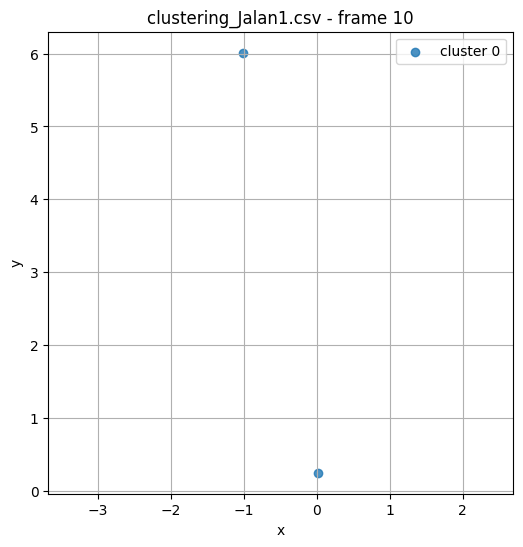

In [19]:
# Cell 10 (opsional): Visualisasi cluster untuk satu frame (2D)

def plot_clusters_for_frame(cluster_file_path: str, frame_id: int):
    """
    Plot 2D (x vs y) titik untuk satu frame tertentu, diwarnai berdasarkan cluster_id.
    Noise (-1) → abu-abu.
    """
    df = pd.read_csv(cluster_file_path)
    df_f = df[df["frame"] == frame_id]
    
    if df_f.empty:
        print(f"Tidak ada data untuk frame {frame_id}")
        return
    
    cluster_ids = df_f["cluster_id"].unique()
    
    plt.figure(figsize=(6, 6))
    for cid in sorted(cluster_ids):
        sub = df_f[df_f["cluster_id"] == cid]
        if cid == -1:
            label = "noise (-1)"
            alpha = 0.3
        else:
            label = f"cluster {cid}"
            alpha = 0.8
        plt.scatter(sub["x"], sub["y"], label=label, alpha=alpha)
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{os.path.basename(cluster_file_path)} - frame {frame_id}")
    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# Contoh:
plot_clusters_for_frame(contoh_file, frame_id=10)
